In [1]:
# To install the packages you'll need, try:
# Pkg.clone("https://github.com/rdeits/DrakeVisualizer.jl.git")
# Pkg.clone("https://github.com/rdeits/SpatialFields.jl")
# Pkg.clone("https://github.com/rdeits/LCMGL.jl")
# Pkg.build("LCMGL")
# Pkg.add("Interact")
# Pkg.add("Images")

using DrakeVisualizer
using SpatialFields
using LCMGL
using Interact
using GeometryTypes
using Images
using AffineTransforms

In [2]:
data = readdlm("box_on_table_points.txt", ',')
surface_points = Point{3, Float64}[vec(data[i,:]) for i in 2:size(data, 1)]

camera = Point{3, Float64}(vec(data[1,:]))
interior_points = [camera]

for i = 1:length(surface_points)
    p = surface_points[i]
    ray_to_camera = camera - p
    ray_to_camera /= norm(ray_to_camera)
    
    push!(interior_points, p + 0.02 * ray_to_camera)
end

In [3]:
vis = Visualizer()
points = vcat(surface_points, interior_points)
values = vcat([0. for p in surface_points], [-1.], [-0.02 for p in 2:length(interior_points)])
field = InterpolatingSurface(points, values, SpatialFields.XCubed())
window = HyperRectangle(Vec(minimum(surface_points)), Vec(maximum(surface_points) - minimum(surface_points)))

LCMGLClient("points") do lcmgl
    for i = 1:length(points)
        if values[i] == 0
            color(lcmgl, 0, 0, 0)
        else
            color(lcmgl, 0, 0, 1)
        end
        sphere(lcmgl, convert(Vector, points[i]), 0.005, 10, 10)
    end
    switch_buffer(lcmgl)
end

In [4]:
gradient = grad(field)

LCMGLClient("normals") do lcmgl
    color(lcmgl, 0, 0, 0)
    begin_mode(lcmgl, LCMGL.LINES)
    for i = 1:length(surface_points)
        p = surface_points[i]
        g = evaluate(gradient, p)
        u = p - 0.05 * Point(g / norm(g))
        vertex(lcmgl, p[1], p[2], p[3])
        vertex(lcmgl, u[1], u[2], u[3])
    end
    end_mode(lcmgl)
    switch_buffer(lcmgl)
end

In [5]:
@manipulate for iso = -.1:0.01:.1
    mesh = SpatialFields.surface_mesh(field, window, iso, 10)
    DrakeVisualizer.load(vis, GeometryData(mesh))
end

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"iso",0.0,-0.1:0.01:0.1,true)

nothing

In [9]:
function generateKinectRays(rows, cols)
    camera_cx = cols / 2.
    camera_cy = rows / 2.
    tan_vert_fov = tan(0.4682)
    tan_hor_fov = tan(0.5449)
    
    rays = Array{Point{3, Float64}}(rows, cols)
    
    for v in 1:rows
        for u in 1:cols
            rays[v, u] = Point{3, Float64}(
            (u - camera_cx) * tan_vert_fov / camera_cx,
            (v - camera_cy) * tan_hor_fov / camera_cy,
                    1.0
                )
            rays[v, u] /= norm(rays[v, u])
        end
    end
    return rays
end
kinect_rows = 48
kinect_cols = 64
kinect_rays = generateKinectRays(kinect_rows, kinect_cols);

In [14]:
function doRaycast(camera_origin, camera_view_ray, field::ScalarField)
    EPS = 1E-5
    SAFE_RATE = 1.0
    SAFE_ITER_LIMIT = 10
    dist = 0
    k = 0
    while (abs(evaluate(field, camera_origin + dist*camera_view_ray)) > EPS && k < SAFE_ITER_LIMIT)
        dist = dist - SAFE_RATE*evaluate(field, camera_origin + dist*camera_view_ray)
        k += 1
    end
    return dist
end


# Define camera info
# camera origin defined above as "camera"
camera_origin = camera
camera_rotation = [0, -1.8, 0.7]
camera_transform = tformrotate([0, 0, 1], camera_rotation[3])*tformrotate([0, 1, 0], camera_rotation[2])*tformrotate([1, 0, 0], camera_rotation[1])
camera_view_rays = Point{3, Float64}[tformfwd(camera_transform, Vector(kinect_rays[i])) for i=1:length(kinect_rays)]
camera_view_center = Point{3, Float64}[-1, -1, -1]
camera_view_center /= norm(camera_view_center)

# Do raycast
distances = [doRaycast(camera_origin, camera_view_rays[i], field) for i in 1:length(camera_view_rays)];

# Draw the points from the raycast back into the world
LCMGLClient("raycast") do lcmgl
    for i = 1:length(distances)
        color(lcmgl, 0, 1, 0)
        sphere(lcmgl, convert(Vector, camera_origin + distances[i]*camera_view_rays[i]), 0.005, 10, 10)
    end
    switch_buffer(lcmgl)
end

Interact.Slider{Float64}(Signal{Float64}(0.8, nactions=0),"minf",0.8,0.0:0.1:1.6,true)

Interact.Slider{Float64}(Signal{Float64}(1.3, nactions=0),"maxf",1.3,0.0:0.1:2.6,true)

 in depwarn at deprecated.jl:73
 in float32 at deprecated.jl:50
 in anonymous at In[8]:5
 in include_string at loading.jl:282
 in execute_request_0x535c5df2 at /home/gizatt/.julia/v0.4/IJulia/src/execute_request.jl:182
 in eventloop at /home/gizatt/.julia/v0.4/IJulia/src/IJulia.jl:142
 in anonymous at task.jl:447
while loading In[8], in expression starting on line 1


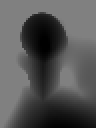

In [8]:
@manipulate for minf = 0:0.1:1.6, maxf = 0.0:0.1:2.6
    distances_bounded = [min(max(distances[i], minf), maxf)-minf for i=1:length(distances)]
    # gotta flip it around a bit
    imagearray = transpose(reshape(distances_bounded, kinect_rows, kinect_cols))
    imagearray = imagearray[end:-1:1,:]
    # drawww
    convert(Image, float32(imagearray))
end